The VarQTE module can be used to run the Variational Quantum Imaginary Time Evolution (VarQITE) or the Variational Quantum Real Time Evolution (VarQRTE) algorithms.  This is done through:
1. Constructing the problem Hamiltonian as a qiskit SparsePauliOp object
2. Constructing the initial state with a qiskit QuantumCircuit object
3. Calling VarQITE or VarQRTE with the desired hyperparameters.

VarQITE and VarQRTE run their corresponding algorithms with a twolocal ansatz, and these functions return the parameter values of the twolocal ansatz at each timestep.  These parameter values can be used to measure useful observables such as the energy, or a custom obervable.  This can be done by calling the ansatz_energy function from the VarQTE module to return the energy of the given timestep, or the Construct_Ansatz function to directly return the twolocal ansatz with the corresponding parameter values, which can be used to measure custom observables.

### Import Dependencies

In [ ]:
!pip install qflux

ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


In [7]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from qflux.closed_systems.VarQTE import VarQITE, VarQRTE, ansatz_energy, Construct_Ansatz

# VarQITE

We begin with the Wick-Rotated Schrodinger equation, and apply McLachlan's Variational Principle,
\begin{equation}
    \delta ||(\frac{d}{d\tau} + \mathcal{H} - E_{\tau})\ket{\psi(\tau)}|| = 0.
\end{equation}

Assuming we have a parameterized ansatz,
\begin{equation}
    \ket{\psi(\tau)} = \ket{\psi(\theta(\tau))}
\end{equation}

This simplifies to a system of linear equations,
\begin{equation}
    \sum_j A_{ij} \dot\theta_j = C_i,
\end{equation}

Where,
\begin{equation}
    A_{ij} = \Re(\frac{\partial\bra{\phi(\theta(\tau))}}{\partial\theta_i}\frac{\partial\ket{\phi(\theta(\tau))}}{\partial\theta_j}),
\end{equation}
and
\begin{equation}
    C_i = - \Re(\bra{\frac{\partial\phi(\theta(\tau))}{\partial\theta_i}}\mathcal{H}\ket{\phi(\theta(\tau))}).
\end{equation}

These $A_{ij}$ and $C_i$ values are measured in a quantum computer and used to determine how to change the paramters of the ansatz $\theta(\tau + d\tau) = \theta(\tau) + \dot\theta d\tau$ to evolve the system through imaginary time.

## Demonstration


```python
# Define the problem Hamiltonian
H = SparsePauliOp.from_list([("Z", 1.0)])
# Set up the initial state using a qiskit QuantumCircuit
qc = QuantumCircuit(3)
# Set Hyperparameters for VarQITE such as number of layers in ansatz, total evolution time, and timestep size
layers = 0
total_time = 10
timestep = 0.1
# Call VarQITE to run the time evolution and output the ansatz parameter values
params = VarQITE(layers, H, total_time, timestep, init_circ=qc)

# These parameter values can be used to measure the energy
my_energy, my_stdev = ansatz_energy(qc, params[i], H)

# Or the parameters can be used to measure custom observables
# Define the observable
observable = SparsePauliOp.from_list([("Z", 1.0)])
# Construct the ansatz circuit
ansatz = Construct_Ansatz(qc, params[i], H.num_qubits)
# Get the resulting values of the observable
result = estimator.run(ansatz, observables=observable).result()
```

### Define the Hamiltonian of interest

In [2]:
H = SparsePauliOp.from_list([("IIZ", 1.0), ("IZI", 1.0), ("ZII", 0.65), ("IXX", 1.0), ("IYY", 1.0), ("XXI", 0.75), ("YYI", 0.75)])

### Create the initial state and run VarQITE

In [ ]:
qc = QuantumCircuit(3)
qc.rx(0.5, 0)
qc.rx(0.5, 1)
qc.rx(0.5, 2)

layers = 0
total_time = 10
timestep = 0.1
params = VarQITE(layers, H, total_time, timestep, init_circ=qc)
# Params now holds the parameter values for the ansatz at each timestep for Imaginary-Time Evolution

Timestep 0 Energy: (2.726775506117946, 0.15198543956298582)
Timestep 1 Energy: (2.7218452829618265, 0.165505891073785)
Timestep 2 Energy: (2.717865405633354, 0.1812541313618672)
Timestep 3 Energy: (2.720977251794712, 0.19277977108898714)
Timestep 4 Energy: (2.709067421721166, 0.22254035435291364)
Timestep 5 Energy: (2.70088036403275, 0.2412302850941499)
Timestep 6 Energy: (2.6854235699334725, 0.2806972445338678)
Timestep 7 Energy: (2.674396101683743, 0.3278261155651654)
Timestep 8 Energy: (2.6644408076372113, 0.3708108570387578)
Timestep 9 Energy: (2.6498750231903188, 0.4339481408895738)
Timestep 10 Energy: (2.6307377875857383, 0.512346887427781)
Timestep 11 Energy: (2.6037848105535204, 0.5965372727567617)
Timestep 12 Energy: (2.5745280978514162, 0.6909838885512416)
Timestep 13 Energy: (2.5489444271678394, 0.8413790600970863)
Timestep 14 Energy: (2.52527181294393, 0.9993195864424145)
Timestep 15 Energy: (2.4539783814668557, 1.1932732816876266)
Timestep 16 Energy: (2.3954314355174606, 1

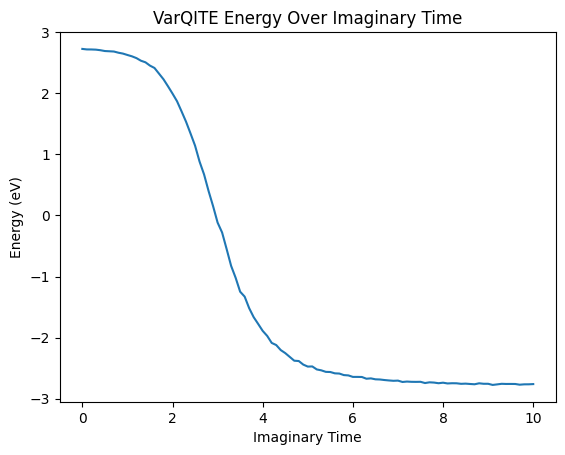

In [15]:
all_energies = []
for i in range(len(params)):
    print(f"Timestep {i} Energy: {ansatz_energy(qc, params[i], H)}")
    all_energies.append(ansatz_energy(qc, params[i], H)[0])

plt.title("VarQITE Energy Over Imaginary Time")
plt.plot([i*timestep for i in range(int(total_time/timestep)+1)], all_energies)
plt.xlabel("Imaginary Time")
plt.ylabel("Energy (eV)")
plt.show()

The Variational Quantum Imaginary Time Evolution (VarQITE) algorithm will converge to the ground state of a system as it is evolved through imaginary time, given that the ansatz is large enough.  This can be used to estimate the ground state energy of a system by measuring the energy of the system at long imaginary-time, as can be seen above.

# VarQRTE

We begin with the Schrodinger equation, and apply McLachlan's Variational Principle,
\begin{equation}
    \delta ||(\frac{d}{dt} -i\mathcal{H} - E_{t})\ket{\psi(t)}|| = 0.
\end{equation}

Assuming we have a parameterized ansatz,
\begin{equation}
    \ket{\psi(t)} = \ket{\psi(\theta(t))}
\end{equation}

This simplifies to a system of linear equations,
\begin{equation}
    \sum_j A_{ij} \dot\theta_j = C_i,
\end{equation}

Where,
\begin{equation}
    A_{ij} = \Re(\frac{\partial\bra{\phi(\theta(t))}}{\partial\theta_i}\frac{\partial\ket{\phi(\theta(t))}}{\partial\theta_j}),
\end{equation}
and
\begin{equation}
    C_i = - \Im(\bra{\frac{\partial\phi(\theta(t))}{\partial\theta_i}}\mathcal{H}\ket{\phi(\theta(t))}).
\end{equation}

These $A_{ij}$ and $C_i$ values are measured in a quantum computer and used to determine how to change the paramters of the ansatz $\theta(t+dt) = \theta(t) + \dot\theta dt$ to evolve the system through real time.

## Demonstration


```python
# Define the problem Hamiltonian
H = SparsePauliOp.from_list([("Z", 1.0)])
# Set up the initial state using a qiskit QuantumCircuit
qc = QuantumCircuit(3)
# Set Hyperparameters for VarQRTE such as number of layers in ansatz, total evolution time, and timestep size
layers = 0
total_time = 10
timestep = 0.1
# Call VarQRTE to run the time evolution and output the ansatz parameter values
params = VarQRTE(layers, H, total_time, timestep, init_circ=qc)

# These parameter values can be used to measure the energy
my_energy, my_stdev = ansatz_energy(qc, params[i], H)

# Or the parameters can be used to measure custom observables
# Define the observable
observable = SparsePauliOp.from_list([("Z", 1.0)])
# Construct the ansatz circuit
ansatz = Construct_Ansatz(qc, params[i], H.num_qubits)
# Get the resulting values of the observable
result = estimator.run(ansatz, observables=observable).result()
```

### Create the initial state and run VarQRTE

In [38]:
H = SparsePauliOp.from_list([("X", 1.0)])

In [46]:
qc = QuantumCircuit(1)
qc.x(0) # Creates |1> state

layers = 1
total_time = 12
timestep = 0.1
params = VarQRTE(layers, H, total_time, timestep, init_circ=qc)
# Params now holds the parameter values for the ansatz at each timestep for Real-Time Evolution

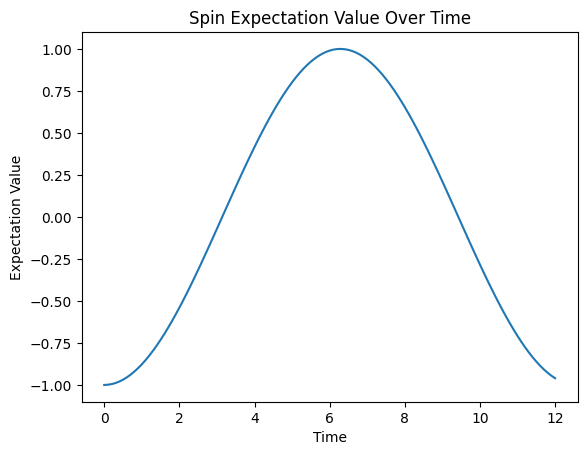

In [47]:
from qiskit.primitives import Estimator

estimator = Estimator()
observable = SparsePauliOp.from_list([("Z", 1.0)])
spin1_values = []
spin2_values = []
for i in range(len(params)):
    ansatz = Construct_Ansatz(qc, params[i], H.num_qubits)
    result = estimator.run(ansatz, observables=observable).result()
    spin1_values.append(result.values[0])

plt.title("Spin Expectation Value Over Time")
plt.plot([i*timestep for i in range(int(total_time/timestep)+1)], spin1_values)
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.show()

This result matches our intuition that the evolution of the system provided above should follow a sine wave as it is evolved through real-time.